# Cryptocurrency Price Prediction with AUTO TS

'description': 'Bitcoin (BTC) is a cryptocurrency . Users are able to generate BTC through the process of mining. 
Bitcoin has a current supply of 19,257,443. The last known price of Bitcoin is 17,217.46558683 USD and is up 0.17 
over the last 24 hours. It is currently trading on 9923 active market(s) with $17,485,048,158.87 traded over the last 24 hours. 
More information can be found at https://bitcoin.org/.',

Fontes:
https://thecleverprogrammer.com/2021/12/27/cryptocurrency-price-prediction-with-machine-learning/
https://thecleverprogrammer.com/2021/04/19/autots-in-python-tutorial/
https://www.analyticsvidhya.com/blog/2021/04/automate-time-series-forecasting-using-auto-ts/
https://github.com/AutoViML/Auto_TS
https://mariofilho.com/as-metricas-mais-populares-para-avaliar-modelos-de-machine-learning/


To do:
1. Source:https://finance.yahoo.com/
2. API: https://github.com/ranaroussi/yfinance; https://pypi.org/project/yfinance/
3. Get and process data
4. Create graph visualization
5. Create predict model using AUTO TS
6. Split data test and train
7. Compare results to verify accuracy...


pip install auto-ts --upgrade --user
pip install auto-ts --upgrade

In [44]:
# Import modules:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from autots import AutoTS
from auto_ts import auto_timeseries
import yfinance as yf
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [4]:
# Get and process Bitcoin prices data from yfinance:
btc = yf.Ticker('BTC-USD')

In [5]:
btc

yfinance.Ticker object <BTC-USD>

In [8]:
# Description about Bitcoin:
btc.info['description']

TypeError: 'NoneType' object is not subscriptable

In [9]:
# Create a history price data frame:
df_btc = btc.history(period="max")

In [10]:
# Rename columns:
df_btc = df_btc.rename({'Open':'open', 'High':'high', 'Low':'low', 'Close':'close', 'Volume':'volume', 
                        'Dividends':'dividends', 'Stock Splits':'stock_splits'}, axis=1)

In [11]:
# Add column with date information and reset index:
df_btc['date'] = df_btc.index
df_btc.reset_index(drop=True, inplace=True)

In [12]:
# Rearrange columns order:
df_btc = df_btc[['date','open', 'high', 'low', 'close', 'volume', 'dividends', 'stock_splits']]

In [13]:
# Print first ten rows:
df_btc.head(10)

,date,open,high,low,close,volume,dividends,stock_splits
0,2014-09-17 00:00:00+00:00,465.864014,468.174011,452.421997,457.334015,21056800,0.0,0.0
1,2014-09-18 00:00:00+00:00,456.859985,456.859985,413.104004,424.440002,34483200,0.0,0.0
2,2014-09-19 00:00:00+00:00,424.102997,427.834991,384.532013,394.795990,37919700,0.0,0.0
3,2014-09-20 00:00:00+00:00,394.673004,423.295990,389.882996,408.903992,36863600,0.0,0.0
4,2014-09-21 00:00:00+00:00,408.084991,412.425995,393.181000,398.821014,26580100,0.0,0.0
5,2014-09-22 00:00:00+00:00,399.100006,406.915985,397.130005,402.152008,24127600,0.0,0.0
6,2014-09-23 00:00:00+00:00,402.092010,441.557007,396.196991,435.790985,45099500,0.0,0.0
7,2014-09-24 00:00:00+00:00,435.751007,436.112000,421.131989,423.204987,30627700,0.0,0.0
8,2014-09-25 00:00:00+00:00,423.156006,423.519989,409.467987,411.574005,26814400,0.0,0.0
9,2014-09-26 00:00:00+00:00,411.428986,414.937988,400.009003,404.424988,21460800,0.0,0.0


In [14]:
# Date convert type:
df_btc.date = pd.to_datetime(df_btc.date)

In [15]:
# Check missing values:
df_btc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3041 entries, 0 to 3040
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype              
---  ------        --------------  -----              
 0   date          3041 non-null   datetime64[ns, UTC]
 1   open          3041 non-null   float64            
 2   high          3041 non-null   float64            
 3   low           3041 non-null   float64            
 4   close         3041 non-null   float64            
 5   volume        3041 non-null   int64              
 6   dividends     3041 non-null   float64            
 7   stock_splits  3041 non-null   float64            
dtypes: datetime64[ns, UTC](1), float64(6), int64(1)
memory usage: 190.2 KB


In [16]:
# Using just the feature named "Close" which is the stock price close by day:
df_btc = df_btc[["date", "close"]]

In [17]:
# Sort values by date:
df_btc = df_btc.sort_values('date')

In [18]:
# Use ratio 90:10 to split test and train data, it means 90% of the data for training and 10% for test:
count_lines = df_btc.shape[0]
limit = int(count_lines*0.9)

In [19]:
# Split train-test dataset:
df_train = df_btc.iloc[:limit]
df_test = df_btc.iloc[limit:]

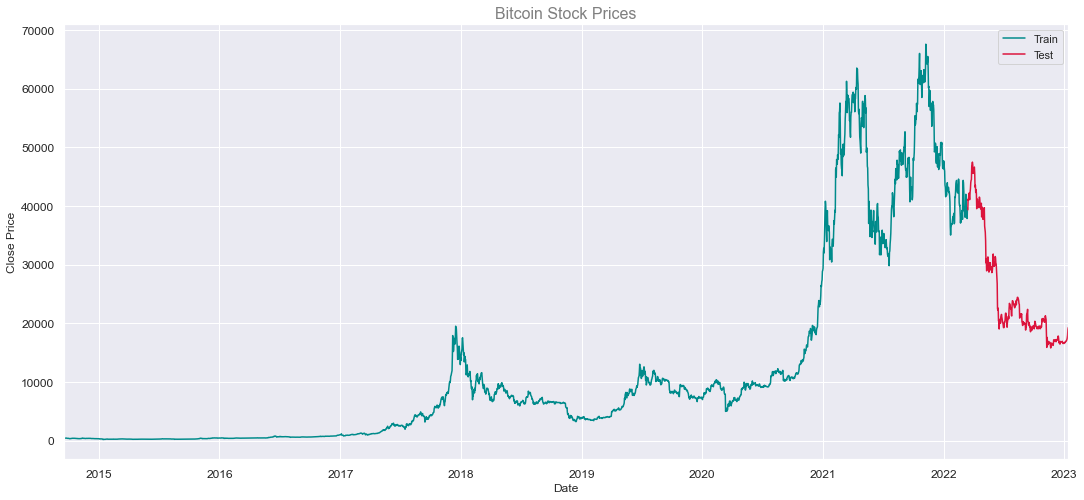

In [20]:
# Graph:

df_train_graph = df_train.set_index('date')
df_test_graph = df_test.set_index('date')


sns.set_theme()
df_train_graph.close.plot( figsize=(18,8), fontsize=12, label='Train', color='DarkCyan')
df_test_graph.close.plot(figsize=(18,8), fontsize=12, label='Test', color='Crimson')
plt.legend()
plt.title("Bitcoin Stock Prices", fontsize=16, color='Grey')
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.show()

In [21]:

model = AutoTS(forecast_length=304, frequency='infer', ensemble='simple')

In [22]:
model = model.fit(df_train, date_col='date', value_col='close', id_col=None)

Inferred frequency is: D
Model Number: 1 with model ARIMA in generation 0 of 10
Model Number: 2 with model ARIMA in generation 0 of 10
Model Number: 3 with model ARIMA in generation 0 of 10
Model Number: 4 with model AverageValueNaive in generation 0 of 10
Model Number: 5 with model AverageValueNaive in generation 0 of 10
Model Number: 6 with model AverageValueNaive in generation 0 of 10
Model Number: 7 with model DatepartRegression in generation 0 of 10
Model Number: 8 with model DatepartRegression in generation 0 of 10
Model Number: 9 with model DatepartRegression in generation 0 of 10
Model Number: 10 with model DatepartRegression in generation 0 of 10
Template Eval Error: ImportError('Tensorflow not available, install with pip install tensorflow.') in model 10: DatepartRegression
Model Number: 11 with model ETS in generation 0 of 10
Model Number: 12 with model ETS in generation 0 of 10
Model Number: 13 with model GLM in generation 0 of 10
Model Number: 14 with model GLM in generati

[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-2)]: Done 186 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-2)]: Done 200 out of 200 | elapsed:    1.0s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks   

Model Number: 41 with model MultivariateRegression in generation 0 of 10
Template Eval Error: ValueError("regression_type='User' but not future_regressor supplied.") in model 41: MultivariateRegression
Model Number: 42 with model DatepartRegression in generation 0 of 10
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 42: DatepartRegression
Model Number: 43 with model SeasonalNaive in generation 0 of 10
Model Number: 44 with model DatepartRegression in generation 0 of 10
Model Number: 45 with model UnobservedComponents in generation 0 of 10
Model Number: 46 with model UnobservedComponents in generation 0 of 10
Model Number: 47 with model ETS in generation 0 of 10
Model Number: 48 with model VECM in generation 0 of 10
Template Eval Error: ValueError('Only gave one variable to VECM') in model 48: VECM
Model Number: 49 with model ARDL in generation 0 of 10
Model Number: 50 with model MultivariateMotif in generation 0 of 10
Model Number: 51 

[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 100 out of 100 | elapsed:    0.0s finished


Model Number: 60 with model NVAR in generation 0 of 10
Model Number: 61 with model Theta in generation 0 of 10
Model Number: 62 with model UnivariateRegression in generation 0 of 10
Model Number: 63 with model ARCH in generation 0 of 10
Template Eval Error: ImportError('`arch` package must be installed from pip') in model 63: ARCH
Model Number: 64 with model ConstantNaive in generation 0 of 10
Model Number: 65 with model LastValueNaive in generation 0 of 10
Model Number: 66 with model AverageValueNaive in generation 0 of 10
Model Number: 67 with model GLS in generation 0 of 10
Model Number: 68 with model SeasonalNaive in generation 0 of 10
Model Number: 69 with model GLM in generation 0 of 10
Template Eval Error: ValueError('regression_type=user and no future_regressor passed') in model 69: GLM
Model Number: 70 with model ETS in generation 0 of 10
ETS error ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
ETS failed on close with Valu

[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-2)]: Done 186 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-2)]: Done 200 out of 200 | elapsed:    0.5s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks   

Model Number: 236 with model LastValueNaive in generation 1 of 10
Model Number: 237 with model GLM in generation 1 of 10
Model Number: 238 with model MetricMotif in generation 1 of 10
Model Number: 239 with model LastValueNaive in generation 1 of 10
Model Number: 240 with model ARIMA in generation 1 of 10
Model Number: 241 with model ARIMA in generation 1 of 10
Model Number: 242 with model MultivariateMotif in generation 1 of 10
Model Number: 243 with model NVAR in generation 1 of 10
Template Eval Error: Exception('Transformer Cointegration failed on fit') in model 243: NVAR
Model Number: 244 with model NVAR in generation 1 of 10
Template Eval Error: Exception('Transformer Cointegration failed on fit') in model 244: NVAR
Model Number: 245 with model GLM in generation 1 of 10
Model Number: 246 with model MultivariateRegression in generation 1 of 10
Model Number: 247 with model DatepartRegression in generation 1 of 10
Model Number: 248 with model DatepartRegression in generation 1 of 10


[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 100 out of 100 | elapsed:    0.0s finished


Model Number: 303 with model Theta in generation 1 of 10
Model Number: 304 with model MultivariateRegression in generation 1 of 10
Model Number: 305 with model ARIMA in generation 1 of 10
No anomalies detected.
Model Number: 306 with model SeasonalNaive in generation 1 of 10
Model Number: 307 with model GLS in generation 1 of 10
Model Number: 308 with model MultivariateRegression in generation 1 of 10
Template Eval Error: ValueError("Input contains NaN, infinity or a value too large for dtype('float64').") in model 308: MultivariateRegression
Model Number: 309 with model ETS in generation 1 of 10
Model Number: 310 with model ARIMA in generation 1 of 10
Model Number: 311 with model MetricMotif in generation 1 of 10
Model Number: 312 with model GLM in generation 1 of 10
Template Eval Error: ValueError('The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.') in model 312: GLM
Model Number: 313 with model DatepartRegression in g

[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 100 out of 100 | elapsed:    0.0s finished


New Generation: 2 of 10
Model Number: 314 with model SeasonalNaive in generation 2 of 10
Model Number: 315 with model MultivariateRegression in generation 2 of 10


[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-2)]: Done 186 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-2)]: Done 200 out of 200 | elapsed:    1.0s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks   

Model Number: 316 with model UnobservedComponents in generation 2 of 10
Model Number: 317 with model ETS in generation 2 of 10
Model Number: 318 with model WindowRegression in generation 2 of 10
Model Number: 319 with model MetricMotif in generation 2 of 10
Model Number: 320 with model MultivariateMotif in generation 2 of 10
Model Number: 321 with model AverageValueNaive in generation 2 of 10
Model Number: 322 with model Theta in generation 2 of 10
Model Number: 323 with model ARIMA in generation 2 of 10
Model Number: 324 with model AverageValueNaive in generation 2 of 10
Model Number: 325 with model AverageValueNaive in generation 2 of 10
Model Number: 326 with model Theta in generation 2 of 10
Model Number: 327 with model ARDL in generation 2 of 10
Model Number: 328 with model GLS in generation 2 of 10
Model Number: 329 with model GLM in generation 2 of 10
Model Number: 330 with model GLM in generation 2 of 10
Template Eval Error: ValueError('regression_type=user and no future_regres

[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-2)]: Done 186 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-2)]: Done 300 out of 300 | elapsed:    1.5s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 300 out of 300 | elapsed:    0.0s finished


Model Number: 356 with model MultivariateRegression in generation 2 of 10
Model Number: 357 with model UnobservedComponents in generation 2 of 10
Model Number: 358 with model MultivariateRegression in generation 2 of 10
Template Eval Error: Exception('Transformer BTCD failed on fit') in model 358: MultivariateRegression
Model Number: 359 with model AverageValueNaive in generation 2 of 10
Model Number: 360 with model UnivariateRegression in generation 2 of 10
Model Number: 361 with model ConstantNaive in generation 2 of 10
Model Number: 362 with model MultivariateMotif in generation 2 of 10
Model Number: 363 with model MultivariateRegression in generation 2 of 10
Model Number: 364 with model AverageValueNaive in generation 2 of 10
Model Number: 365 with model Theta in generation 2 of 10
Model Number: 366 with model UnobservedComponents in generation 2 of 10
Model Number: 367 with model DatepartRegression in generation 2 of 10
Model Number: 368 with model MultivariateRegression in genera

[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-2)]: Done 186 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-2)]: Done 200 out of 200 | elapsed:    1.1s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks   

Model Number: 369 with model GLS in generation 2 of 10
Model Number: 370 with model LastValueNaive in generation 2 of 10
Model Number: 371 with model ETS in generation 2 of 10
Model Number: 372 with model GLS in generation 2 of 10
Model Number: 373 with model SeasonalNaive in generation 2 of 10
Model Number: 374 with model MultivariateRegression in generation 2 of 10
Template Eval Error: ValueError("Input contains NaN, infinity or a value too large for dtype('float64').") in model 374: MultivariateRegression
Model Number: 375 with model UnivariateRegression in generation 2 of 10
Model Number: 376 with model UnivariateRegression in generation 2 of 10
Model Number: 377 with model UnobservedComponents in generation 2 of 10
Model Number: 378 with model LastValueNaive in generation 2 of 10
Model Number: 379 with model UnivariateMotif in generation 2 of 10
Model Number: 380 with model NVAR in generation 2 of 10
Model Number: 381 with model UnivariateMotif in generation 2 of 10
Model Number: 

[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-2)]: Done 186 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-2)]: Done 200 out of 200 | elapsed:    0.6s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks   

Model Number: 390 with model SectionalMotif in generation 2 of 10
Model Number: 391 with model UnobservedComponents in generation 2 of 10
Model Number: 392 with model GLM in generation 2 of 10
Template Eval Error: Exception('Transformer Detrend failed on fit') in model 392: GLM
Model Number: 393 with model ARIMA in generation 2 of 10
Model Number: 394 with model NVAR in generation 2 of 10
Model Number: 395 with model DatepartRegression in generation 2 of 10
Model Number: 396 with model ETS in generation 2 of 10
Model Number: 397 with model Theta in generation 2 of 10
Model Number: 398 with model SeasonalNaive in generation 2 of 10
Model Number: 399 with model LastValueNaive in generation 2 of 10
Model Number: 400 with model Theta in generation 2 of 10
Model Number: 401 with model SectionalMotif in generation 2 of 10
Model Number: 402 with model Theta in generation 2 of 10
Model Number: 403 with model MultivariateRegression in generation 2 of 10
Model Number: 404 with model UnivariateMo

[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-2)]: Done 186 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-2)]: Done 200 out of 200 | elapsed:    1.1s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks   

Model Number: 496 with model DatepartRegression in generation 3 of 10
Model Number: 497 with model GLM in generation 3 of 10
Model Number: 498 with model Theta in generation 3 of 10
Model Number: 499 with model MetricMotif in generation 3 of 10
Model Number: 500 with model MultivariateRegression in generation 3 of 10
Model Number: 501 with model ETS in generation 3 of 10
Model Number: 502 with model UnivariateMotif in generation 3 of 10
Model Number: 503 with model SectionalMotif in generation 3 of 10
Model Number: 504 with model LastValueNaive in generation 3 of 10
Model Number: 505 with model DatepartRegression in generation 3 of 10
Model Number: 506 with model MultivariateRegression in generation 3 of 10


[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-2)]: Done 186 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-2)]: Done 200 out of 200 | elapsed:    0.6s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks   

Model Number: 507 with model ConstantNaive in generation 3 of 10
Model Number: 508 with model NVAR in generation 3 of 10
Model Number: 509 with model Theta in generation 3 of 10
Model Number: 510 with model ETS in generation 3 of 10
Model Number: 511 with model SectionalMotif in generation 3 of 10
Template Eval Error: ValueError("regression_type=='User' but no future_regressor supplied") in model 511: SectionalMotif
Model Number: 512 with model SeasonalNaive in generation 3 of 10
Model Number: 513 with model UnivariateRegression in generation 3 of 10
Model Number: 514 with model NVAR in generation 3 of 10
Model Number: 515 with model ETS in generation 3 of 10
Model Number: 516 with model UnivariateRegression in generation 3 of 10
Template Eval Error: Exception('Transformer Detrend failed on fit') in model 516: UnivariateRegression
Model Number: 517 with model Theta in generation 3 of 10
Model Number: 518 with model ARIMA in generation 3 of 10
Model Number: 519 with model UnobservedComp

[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-2)]: Done 186 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-2)]: Done 200 out of 200 | elapsed:    0.8s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks   

Model Number: 558 with model UnivariateMotif in generation 3 of 10
Model Number: 559 with model ARDL in generation 3 of 10
Model Number: 560 with model AverageValueNaive in generation 3 of 10
Model Number: 561 with model SeasonalNaive in generation 3 of 10
Model Number: 562 with model GLS in generation 3 of 10
Model Number: 563 with model DatepartRegression in generation 3 of 10
New Generation: 4 of 10
Model Number: 564 with model LastValueNaive in generation 4 of 10
Model Number: 565 with model UnivariateRegression in generation 4 of 10
Model Number: 566 with model UnobservedComponents in generation 4 of 10
Template Eval Error: ValueError("regression_type='User' but no future_regressor supplied") in model 566: UnobservedComponents
Model Number: 567 with model DatepartRegression in generation 4 of 10


[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-2)]: Done 186 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-2)]: Done 300 out of 300 | elapsed:    1.8s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 300 out of 300 | elapsed:    0.0s finished


Model Number: 568 with model UnobservedComponents in generation 4 of 10
Model Number: 569 with model MetricMotif in generation 4 of 10
Template Eval Error: Exception('Transformer Detrend failed on fit') in model 569: MetricMotif
Model Number: 570 with model UnobservedComponents in generation 4 of 10
Model Number: 571 with model ETS in generation 4 of 10
Model Number: 572 with model MetricMotif in generation 4 of 10
Model Number: 573 with model MultivariateRegression in generation 4 of 10


[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.9s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_

Model Number: 574 with model AverageValueNaive in generation 4 of 10
Model Number: 575 with model DatepartRegression in generation 4 of 10
Model Number: 576 with model SectionalMotif in generation 4 of 10
Template Eval Error: ValueError("regression_type=='User' but no future_regressor supplied") in model 576: SectionalMotif
Model Number: 577 with model LastValueNaive in generation 4 of 10
Model Number: 578 with model SeasonalNaive in generation 4 of 10
Model Number: 579 with model SeasonalNaive in generation 4 of 10
Model Number: 580 with model ARIMA in generation 4 of 10
Model Number: 581 with model NVAR in generation 4 of 10
Model Number: 582 with model MultivariateRegression in generation 4 of 10
Template Eval Error: ValueError("Model returned NaN due to a preprocessing transformer {'fillna': 'ffill', 'transformations': {'0': 'AlignLastValue', '1': 'PowerTransformer', '2': 'IntermittentOccurrence'}, 'transformation_params': {'0': {'rows': 1, 'lag': 1, 'method': 'additive', 'strength

[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-2)]: Done 186 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-2)]: Done 200 out of 200 | elapsed:    0.9s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks   

Model Number: 603 with model NVAR in generation 4 of 10
Model Number: 604 with model Theta in generation 4 of 10
Model Number: 605 with model Theta in generation 4 of 10
Model Number: 606 with model LastValueNaive in generation 4 of 10
Model Number: 607 with model AverageValueNaive in generation 4 of 10
Model Number: 608 with model UnobservedComponents in generation 4 of 10
Model Number: 609 with model ETS in generation 4 of 10
Model Number: 610 with model SeasonalNaive in generation 4 of 10
Model Number: 611 with model DatepartRegression in generation 4 of 10
Model Number: 612 with model GLM in generation 4 of 10
Model Number: 613 with model UnobservedComponents in generation 4 of 10
Model Number: 614 with model GLM in generation 4 of 10
Template Eval Error: ValueError('The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.') in model 614: GLM
Model Number: 615 with model LastValueNaive in generation 4 of 10
Model Number: 61

[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-2)]: Done 186 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-2)]: Done 200 out of 200 | elapsed:    1.0s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks   

Model Number: 623 with model ARIMA in generation 4 of 10
Model Number: 624 with model MetricMotif in generation 4 of 10
Model Number: 625 with model AverageValueNaive in generation 4 of 10
Model Number: 626 with model GLM in generation 4 of 10
Model Number: 627 with model UnivariateRegression in generation 4 of 10
Model Number: 628 with model NVAR in generation 4 of 10
Model Number: 629 with model ARIMA in generation 4 of 10
Model Number: 630 with model ETS in generation 4 of 10
Model Number: 631 with model MultivariateRegression in generation 4 of 10
Model Number: 632 with model ETS in generation 4 of 10
Model Number: 633 with model MetricMotif in generation 4 of 10
Model Number: 634 with model LastValueNaive in generation 4 of 10
Model Number: 635 with model SectionalMotif in generation 4 of 10
Model Number: 636 with model AverageValueNaive in generation 4 of 10
Model Number: 637 with model UnobservedComponents in generation 4 of 10
Model Number: 638 with model ARIMA in generation 4 

[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 100 out of 100 | elapsed:    0.0s finished


Model Number: 653 with model Theta in generation 4 of 10
Model Number: 654 with model ARIMA in generation 4 of 10
Model Number: 655 with model LastValueNaive in generation 4 of 10
Model Number: 656 with model GLS in generation 4 of 10
Model Number: 657 with model SectionalMotif in generation 4 of 10
Model Number: 658 with model Theta in generation 4 of 10
Model Number: 659 with model SeasonalNaive in generation 4 of 10
Model Number: 660 with model UnobservedComponents in generation 4 of 10
Model Number: 661 with model DatepartRegression in generation 4 of 10
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]Model Number: 662 with model ARIMA in generation 4 of 10
Model Number: 663 with model ConstantNaive in generation 4 of 10
Model Number: 664 with model SeasonalNaive in generation 4 of 10
Model Number: 665 with model MultivariateMotif in generation 4 of 10
Model Number: 666 with mo

[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-2)]: Done 186 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-2)]: Done 300 out of 300 | elapsed:    2.1s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 300 out of 300 | elapsed:    0.0s finished


Model Number: 699 with model SeasonalNaive in generation 5 of 10
Model Number: 700 with model UnobservedComponents in generation 5 of 10
Model Number: 701 with model WindowRegression in generation 5 of 10
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 701: WindowRegression
Model Number: 702 with model SeasonalNaive in generation 5 of 10
Model Number: 703 with model MultivariateRegression in generation 5 of 10
Model Number: 704 with model NVAR in generation 5 of 10
Model Number: 705 with model ETS in generation 5 of 10
Template Eval Error: ValueError("Model returned NaN due to a preprocessing transformer {'fillna': 'rolling_mean', 'transformations': {'0': 'ClipOutliers', '1': 'AlignLastValue', '2': 'PowerTransformer'}, 'transformation_params': {'0': {'method': 'clip', 'std_threshold': 3, 'fillna': None}, '1': {'rows': 1, 'lag': 1, 'method': 'additive', 'strength': 1.0, 'first_value_only': False}, '2': {}}}. fail_on_forecast_nan=True") i

[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 100 out of 100 | elapsed:    0.0s finished


Model Number: 727 with model ARIMA in generation 5 of 10
Model Number: 728 with model NVAR in generation 5 of 10
Template Eval Error: ValueError('Model NVAR returned NaN for one or more series. fail_on_forecast_nan=True') in model 728: NVAR
Model Number: 729 with model NVAR in generation 5 of 10
Template Eval Error: ValueError('Model NVAR returned NaN for one or more series. fail_on_forecast_nan=True') in model 729: NVAR
Model Number: 730 with model MultivariateRegression in generation 5 of 10
Template Eval Error: ValueError("Input contains NaN, infinity or a value too large for dtype('float64').") in model 730: MultivariateRegression
Model Number: 731 with model MultivariateRegression in generation 5 of 10
Model Number: 732 with model LastValueNaive in generation 5 of 10
Model Number: 733 with model UnobservedComponents in generation 5 of 10
Model Number: 734 with model DatepartRegression in generation 5 of 10


[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-2)]: Done 186 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-2)]: Done 300 out of 300 | elapsed:    2.0s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 300 out of 300 | elapsed:    0.0s finished


Model Number: 735 with model MetricMotif in generation 5 of 10
Model Number: 736 with model MultivariateRegression in generation 5 of 10


[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-2)]: Done 186 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-2)]: Done 200 out of 200 | elapsed:    1.4s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks   

Model Number: 737 with model AverageValueNaive in generation 5 of 10
Model Number: 738 with model ETS in generation 5 of 10
ETS error ValueError('Can only dampen the trend component')
ETS failed on close with ValueError('Can only dampen the trend component')
Model Number: 739 with model UnivariateMotif in generation 5 of 10
Model Number: 740 with model UnivariateRegression in generation 5 of 10
Model Number: 741 with model NVAR in generation 5 of 10
Model Number: 742 with model SeasonalNaive in generation 5 of 10
Model Number: 743 with model UnobservedComponents in generation 5 of 10
Model Number: 744 with model MultivariateRegression in generation 5 of 10
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead o

[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-2)]: Done 186 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-2)]: Done 200 out of 200 | elapsed:    0.4s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks   

Model Number: 794 with model SeasonalNaive in generation 6 of 10
Model Number: 795 with model LastValueNaive in generation 6 of 10
Model Number: 796 with model GLS in generation 6 of 10
Model Number: 797 with model DatepartRegression in generation 6 of 10
Model Number: 798 with model GLM in generation 6 of 10
Model Number: 799 with model SectionalMotif in generation 6 of 10
Model Number: 800 with model ETS in generation 6 of 10
Model Number: 801 with model SectionalMotif in generation 6 of 10
Model Number: 802 with model ARDL in generation 6 of 10
Model Number: 803 with model ConstantNaive in generation 6 of 10
Template Eval Error: Exception('Transformer Cointegration failed on fit') in model 803: ConstantNaive
Model Number: 804 with model UnivariateRegression in generation 6 of 10
Model Number: 805 with model UnivariateMotif in generation 6 of 10
Model Number: 806 with model Theta in generation 6 of 10
Model Number: 807 with model ETS in generation 6 of 10
Model Number: 808 with model

[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-2)]: Done 186 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-2)]: Done 200 out of 200 | elapsed:    0.6s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks   

Model Number: 841 with model NVAR in generation 6 of 10
Model Number: 842 with model Theta in generation 6 of 10
Model Number: 843 with model UnobservedComponents in generation 6 of 10
Model Number: 844 with model AverageValueNaive in generation 6 of 10
Model Number: 845 with model ARDL in generation 6 of 10
Model Number: 846 with model SectionalMotif in generation 6 of 10
Template Eval Error: Exception('Transformer Cointegration failed on fit') in model 846: SectionalMotif
Model Number: 847 with model GLS in generation 6 of 10
Model Number: 848 with model WindowRegression in generation 6 of 10
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 848: WindowRegression
Model Number: 849 with model MetricMotif in generation 6 of 10
Model Number: 850 with model AverageValueNaive in generation 6 of 10
Model Number: 851 with model ARDL in generation 6 of 10
Model Number: 852 with model DatepartRegression in generation 6 of 10


[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-2)]: Done 186 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-2)]: Done 300 out of 300 | elapsed:    1.0s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 300 out of 300 | elapsed:    0.0s finished


Model Number: 853 with model ETS in generation 6 of 10
Model Number: 854 with model Theta in generation 6 of 10
Model Number: 855 with model UnobservedComponents in generation 6 of 10
Template Eval Error: ValueError("regression_type='User' but no future_regressor supplied") in model 855: UnobservedComponents
Model Number: 856 with model Theta in generation 6 of 10
Model Number: 857 with model GLS in generation 6 of 10
Model Number: 858 with model MultivariateRegression in generation 6 of 10
Model Number: 859 with model ETS in generation 6 of 10
Model Number: 860 with model Theta in generation 6 of 10
Model Number: 861 with model LastValueNaive in generation 6 of 10
Model Number: 862 with model WindowRegression in generation 6 of 10
Model Number: 863 with model GLM in generation 6 of 10
Template Eval Error: ValueError('NaN, inf or invalid value detected in weights, estimation infeasible.') in model 863: GLM
Model Number: 864 with model GLM in generation 6 of 10
Model Number: 865 with mo

[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-2)]: Done 186 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-2)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 300 out of 300 | elapsed:    0.0s finished


Model Number: 869 with model LastValueNaive in generation 6 of 10
Model Number: 870 with model MetricMotif in generation 6 of 10
Model Number: 871 with model UnobservedComponents in generation 6 of 10
Model Number: 872 with model GLM in generation 6 of 10
Template Eval Error: ValueError('regression_type=user and no future_regressor passed') in model 872: GLM
Model Number: 873 with model GLS in generation 6 of 10
Model Number: 874 with model ETS in generation 6 of 10
Model Number: 875 with model ConstantNaive in generation 6 of 10
Template Eval Error: ValueError("Model returned NaN due to a preprocessing transformer {'fillna': 'mean', 'transformations': {'0': 'HPFilter', '1': 'AlignLastValue', '2': 'AlignLastValue', '3': 'AlignLastValue', '4': 'PowerTransformer'}, 'transformation_params': {'0': {'part': 'trend', 'lamb': 6.25}, '1': {'rows': 1, 'lag': 1, 'method': 'additive', 'strength': 1.0, 'first_value_only': False}, '2': {'rows': 1, 'lag': 1, 'method': 'additive', 'strength': 1.0, 'f

[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-2)]: Done 186 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-2)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 300 out of 300 | elapsed:    0.0s finished


Model Number: 880 with model LastValueNaive in generation 6 of 10
Model Number: 881 with model UnivariateRegression in generation 6 of 10
Model Number: 882 with model DatepartRegression in generation 6 of 10


[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-2)]: Done 186 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-2)]: Done 300 out of 300 | elapsed:    2.1s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 300 out of 300 | elapsed:    0.0s finished


Model Number: 883 with model ETS in generation 6 of 10
Model Number: 884 with model MultivariateRegression in generation 6 of 10
Model Number: 885 with model GLS in generation 6 of 10
Model Number: 886 with model DatepartRegression in generation 6 of 10
Model Number: 887 with model ARIMA in generation 6 of 10
Model Number: 888 with model GLM in generation 6 of 10
New Generation: 7 of 10
Model Number: 889 with model DatepartRegression in generation 7 of 10


[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-2)]: Done 186 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-2)]: Done 300 out of 300 | elapsed:    1.8s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 300 out of 300 | elapsed:    0.0s finished


Model Number: 890 with model AverageValueNaive in generation 7 of 10
Model Number: 891 with model ETS in generation 7 of 10
Model Number: 892 with model MultivariateRegression in generation 7 of 10
Model Number: 893 with model ARIMA in generation 7 of 10
Model Number: 894 with model GLM in generation 7 of 10
Model Number: 895 with model Theta in generation 7 of 10
Model Number: 896 with model MetricMotif in generation 7 of 10
Model Number: 897 with model GLS in generation 7 of 10
Model Number: 898 with model LastValueNaive in generation 7 of 10
Model Number: 899 with model LastValueNaive in generation 7 of 10
Model Number: 900 with model DatepartRegression in generation 7 of 10
Template Eval Error: ImportError('Tensorflow not available, install with pip install tensorflow.') in model 900: DatepartRegression
Model Number: 901 with model DatepartRegression in generation 7 of 10
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 901: Datepart

[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 100 out of 100 | elapsed:    0.0s finished


Model Number: 909 with model LastValueNaive in generation 7 of 10
Model Number: 910 with model UnivariateMotif in generation 7 of 10
Model Number: 911 with model SeasonalNaive in generation 7 of 10
Model Number: 912 with model Theta in generation 7 of 10
Template Eval Error: Exception('Transformer Cointegration failed on fit') in model 912: Theta
Model Number: 913 with model ARDL in generation 7 of 10
Model Number: 914 with model GLM in generation 7 of 10
Model Number: 915 with model ETS in generation 7 of 10
Model Number: 916 with model ETS in generation 7 of 10
Model Number: 917 with model UnivariateMotif in generation 7 of 10
Model Number: 918 with model SectionalMotif in generation 7 of 10
Model Number: 919 with model DatepartRegression in generation 7 of 10


[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-2)]: Done 186 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-2)]: Done 300 out of 300 | elapsed:    1.8s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 300 out of 300 | elapsed:    0.0s finished


Model Number: 920 with model Theta in generation 7 of 10
Model Number: 921 with model ETS in generation 7 of 10
ETS error ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
ETS failed on close with ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
Model Number: 922 with model UnivariateMotif in generation 7 of 10
Model Number: 923 with model MetricMotif in generation 7 of 10
Model Number: 924 with model LastValueNaive in generation 7 of 10
Model Number: 925 with model Theta in generation 7 of 10
Model Number: 926 with model ARIMA in generation 7 of 10
Model Number: 927 with model SectionalMotif in generation 7 of 10
Model Number: 928 with model DatepartRegression in generation 7 of 10
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 928: DatepartRegression
Model Number: 929 with model AverageValueNaive in generation 7 of 10
Model Number: 

[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-2)]: Done 186 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-2)]: Done 300 out of 300 | elapsed:    2.1s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 300 out of 300 | elapsed:    0.1s finished


Model Number: 940 with model ETS in generation 7 of 10
Model Number: 941 with model MultivariateRegression in generation 7 of 10


[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-2)]: Done 186 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-2)]: Done 200 out of 200 | elapsed:    3.1s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks   

Model Number: 942 with model WindowRegression in generation 7 of 10
Model Number: 943 with model ARDL in generation 7 of 10
Model Number: 944 with model Theta in generation 7 of 10
Model Number: 945 with model ARIMA in generation 7 of 10
Model Number: 946 with model DatepartRegression in generation 7 of 10
Model Number: 947 with model MultivariateRegression in generation 7 of 10
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000547 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
Model Number: 948 with model ETS in generation 7 of 10
Model Number: 949 with model DatepartRegression in generation 7 of 10
Model Number: 950 with model SeasonalNaive in generation 7 of 10
Model Number: 951 with model MetricMotif in generation 7 of 10
Model Number: 952 with model LastValueNaive in generation 7 of 10
Model Number: 953 with model UnobservedComponents in generation 7 of 1

[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-2)]: Done 186 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-2)]: Done 436 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-2)]: Done 786 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-2)]: Done 1000 out of 1000 | elapsed:    9.8s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 436 tasks      | elapsed:    0.1s
[Parallel(n_jobs=7)]: Done 786 tasks      | elapsed:    0.3s
[Parallel(n_jobs=7)]: Done 1000 out of 1000 | elapsed:    0.4s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.0s


Model Number: 1003 with model SeasonalNaive in generation 8 of 10
Model Number: 1004 with model SeasonalNaive in generation 8 of 10
Model Number: 1005 with model LastValueNaive in generation 8 of 10
Model Number: 1006 with model SeasonalNaive in generation 8 of 10
Model Number: 1007 with model ARDL in generation 8 of 10
Model Number: 1008 with model GLM in generation 8 of 10
Model Number: 1009 with model MetricMotif in generation 8 of 10
Model Number: 1010 with model LastValueNaive in generation 8 of 10
Model Number: 1011 with model ETS in generation 8 of 10
Model Number: 1012 with model MetricMotif in generation 8 of 10
Model Number: 1013 with model AverageValueNaive in generation 8 of 10
Model Number: 1014 with model ETS in generation 8 of 10
ETS error ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
ETS failed on close with ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
Model Nu

[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-2)]: Done 186 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-2)]: Done 300 out of 300 | elapsed:    1.8s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 300 out of 300 | elapsed:    0.0s finished


Model Number: 1028 with model UnobservedComponents in generation 8 of 10
Template Eval Error: Exception('Transformer Cointegration failed on fit') in model 1028: UnobservedComponents
Model Number: 1029 with model DatepartRegression in generation 8 of 10
Model Number: 1030 with model ARIMA in generation 8 of 10
Model Number: 1031 with model MultivariateMotif in generation 8 of 10
Model Number: 1032 with model ARIMA in generation 8 of 10
Model Number: 1033 with model ARIMA in generation 8 of 10
Model Number: 1034 with model GLS in generation 8 of 10
Model Number: 1035 with model ETS in generation 8 of 10
Model Number: 1036 with model ARIMA in generation 8 of 10
Model Number: 1037 with model NVAR in generation 8 of 10
Model Number: 1038 with model ARDL in generation 8 of 10
Model Number: 1039 with model ARIMA in generation 8 of 10
Model Number: 1040 with model UnivariateMotif in generation 8 of 10
Model Number: 1041 with model AverageValueNaive in generation 8 of 10
Model Number: 1042 wit

[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-2)]: Done 186 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-2)]: Done 300 out of 300 | elapsed:    1.4s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 300 out of 300 | elapsed:    0.0s finished


Model Number: 1050 with model MultivariateMotif in generation 8 of 10
Model Number: 1051 with model ConstantNaive in generation 8 of 10
Model Number: 1052 with model Theta in generation 8 of 10
Model Number: 1053 with model GLS in generation 8 of 10
Model Number: 1054 with model MultivariateRegression in generation 8 of 10


[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-2)]: Done 186 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-2)]: Done 200 out of 200 | elapsed:    2.2s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks   

Model Number: 1055 with model NVAR in generation 8 of 10
Model Number: 1056 with model Theta in generation 8 of 10
Model Number: 1057 with model DatepartRegression in generation 8 of 10
Template Eval Error: ImportError('Tensorflow not available, install with pip install tensorflow.') in model 1057: DatepartRegression
Model Number: 1058 with model ARIMA in generation 8 of 10
Model Number: 1059 with model ETS in generation 8 of 10
Model Number: 1060 with model ETS in generation 8 of 10
Model Number: 1061 with model MultivariateRegression in generation 8 of 10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002303 seconds.
You can set `force_col_wise=true` to remove the overhead.
Model Number: 1062 with model MultivariateRegression in generation 8 of 10
Model Number: 1063 with model Theta in generation 8 of 10
Template Eval Error: Exception('Transformer Cointegration failed on fit') in model 1063: Theta
Model Number: 1064 with model GLM in genera

[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-2)]: Done 186 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-2)]: Done 300 out of 300 | elapsed:    1.1s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 300 out of 300 | elapsed:    0.0s finished


Model Number: 1100 with model GLS in generation 9 of 10
Model Number: 1101 with model LastValueNaive in generation 9 of 10
Model Number: 1102 with model UnivariateRegression in generation 9 of 10
Model Number: 1103 with model NVAR in generation 9 of 10
Model Number: 1104 with model ARIMA in generation 9 of 10
Model Number: 1105 with model SeasonalNaive in generation 9 of 10
Model Number: 1106 with model LastValueNaive in generation 9 of 10
Template Eval Error: Exception('Transformer BTCD failed on fit') in model 1106: LastValueNaive
Model Number: 1107 with model UnobservedComponents in generation 9 of 10
Model Number: 1108 with model LastValueNaive in generation 9 of 10
Model Number: 1109 with model MultivariateMotif in generation 9 of 10
Model Number: 1110 with model ETS in generation 9 of 10
Model Number: 1111 with model NVAR in generation 9 of 10
Model Number: 1112 with model Theta in generation 9 of 10
Model Number: 1113 with model SectionalMotif in generation 9 of 10
Model Number:

[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-2)]: Done 186 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-2)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 300 out of 300 | elapsed:    0.0s finished


Model Number: 1142 with model ARIMA in generation 9 of 10
Model Number: 1143 with model LastValueNaive in generation 9 of 10
Model Number: 1144 with model Theta in generation 9 of 10
Model Number: 1145 with model ARDL in generation 9 of 10
Model Number: 1146 with model SectionalMotif in generation 9 of 10
Model Number: 1147 with model NVAR in generation 9 of 10
Model Number: 1148 with model ARDL in generation 9 of 10
Model Number: 1149 with model ETS in generation 9 of 10
Model Number: 1150 with model UnivariateMotif in generation 9 of 10
Model Number: 1151 with model UnobservedComponents in generation 9 of 10
Model Number: 1152 with model DatepartRegression in generation 9 of 10


[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-2)]: Done 186 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-2)]: Done 300 out of 300 | elapsed:    0.7s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 300 out of 300 | elapsed:    0.0s finished


Model Number: 1153 with model ARIMA in generation 9 of 10
Model Number: 1154 with model SeasonalNaive in generation 9 of 10
Model Number: 1155 with model MetricMotif in generation 9 of 10
Model Number: 1156 with model AverageValueNaive in generation 9 of 10
Model Number: 1157 with model ETS in generation 9 of 10
ETS error ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
ETS failed on close with ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
Model Number: 1158 with model Theta in generation 9 of 10
Model Number: 1159 with model MultivariateMotif in generation 9 of 10
Model Number: 1160 with model MultivariateRegression in generation 9 of 10
Model Number: 1161 with model MultivariateRegression in generation 9 of 10


[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-2)]: Done 186 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-2)]: Done 200 out of 200 | elapsed:    0.4s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks   

Model Number: 1162 with model UnivariateRegression in generation 9 of 10
Model Number: 1163 with model ARDL in generation 9 of 10
Model Number: 1164 with model MultivariateRegression in generation 9 of 10
Model Number: 1165 with model SeasonalNaive in generation 9 of 10
Model Number: 1166 with model AverageValueNaive in generation 9 of 10
Model Number: 1167 with model ARIMA in generation 9 of 10
Model Number: 1168 with model SeasonalNaive in generation 9 of 10
Model Number: 1169 with model LastValueNaive in generation 9 of 10
Model Number: 1170 with model NVAR in generation 9 of 10
Model Number: 1171 with model Theta in generation 9 of 10
Model Number: 1172 with model LastValueNaive in generation 9 of 10
Model Number: 1173 with model LastValueNaive in generation 9 of 10
Model Number: 1174 with model MultivariateRegression in generation 9 of 10
Template Eval Error: XGBoostError('[16:56:22] C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xg

[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-2)]: Done 186 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-2)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 300 out of 300 | elapsed:    0.0s finished


Model Number: 1204 with model MetricMotif in generation 10 of 10
Model Number: 1205 with model SectionalMotif in generation 10 of 10
Model Number: 1206 with model DatepartRegression in generation 10 of 10
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 1206: DatepartRegression
Model Number: 1207 with model Theta in generation 10 of 10
Model Number: 1208 with model Theta in generation 10 of 10
Template Eval Error: Exception('Transformer Cointegration failed on fit') in model 1208: Theta
Model Number: 1209 with model SeasonalNaive in generation 10 of 10
Model Number: 1210 with model GLS in generation 10 of 10
Model Number: 1211 with model SectionalMotif in generation 10 of 10
Model Number: 1212 with model ARIMA in generation 10 of 10
Model Number: 1213 with model DatepartRegression in generation 10 of 10


[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-2)]: Done 186 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-2)]: Done 300 out of 300 | elapsed:    0.7s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 300 out of 300 | elapsed:    0.0s finished


Model Number: 1214 with model Theta in generation 10 of 10
Template Eval Error: Exception('Transformer Cointegration failed on fit') in model 1214: Theta
Model Number: 1215 with model LastValueNaive in generation 10 of 10
Model Number: 1216 with model ARIMA in generation 10 of 10
Model Number: 1217 with model LastValueNaive in generation 10 of 10
Model Number: 1218 with model MultivariateRegression in generation 10 of 10
Model Number: 1219 with model LastValueNaive in generation 10 of 10
Model Number: 1220 with model MultivariateRegression in generation 10 of 10
Model Number: 1221 with model LastValueNaive in generation 10 of 10
Model Number: 1222 with model Theta in generation 10 of 10
Model Number: 1223 with model Theta in generation 10 of 10
Model Number: 1224 with model SeasonalNaive in generation 10 of 10
Model Number: 1225 with model LastValueNaive in generation 10 of 10
Model Number: 1226 with model ETS in generation 10 of 10
Model Number: 1227 with model ETS in generation 10 of

[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-2)]: Done 186 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-2)]: Done 200 out of 200 | elapsed:    0.4s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks   

Model Number: 1247 with model GLM in generation 10 of 10
Model Number: 1248 with model Theta in generation 10 of 10
Model Number: 1249 with model SeasonalNaive in generation 10 of 10
Model Number: 1250 with model SeasonalNaive in generation 10 of 10
Model Number: 1251 with model GLM in generation 10 of 10
Model Number: 1252 with model MetricMotif in generation 10 of 10
Model Number: 1253 with model DatepartRegression in generation 10 of 10
Model Number: 1254 with model ETS in generation 10 of 10
ETS error ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
ETS failed on close with ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
Model Number: 1255 with model ARIMA in generation 10 of 10
Model Number: 1256 with model SectionalMotif in generation 10 of 10
Model Number: 1257 with model LastValueNaive in generation 10 of 10
Model Number: 1258 with model Theta in generation 10 of 10
Model Nu

[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-2)]: Done 186 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-2)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 300 out of 300 | elapsed:    0.0s finished


48 - DatepartRegression with avg smape 80.76: 
Model Number: 49 of 188 with model UnobservedComponents for Validation 1
49 - UnobservedComponents with avg smape 94.37: 
Model Number: 50 of 188 with model UnobservedComponents for Validation 1
50 - UnobservedComponents with avg smape 94.37: 
Model Number: 51 of 188 with model ETS for Validation 1
51 - ETS with avg smape 79.92: 
Model Number: 52 of 188 with model DatepartRegression for Validation 1


[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-2)]: Done 186 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-2)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 300 out of 300 | elapsed:    0.0s finished


52 - DatepartRegression with avg smape 80.69: 
Model Number: 53 of 188 with model DatepartRegression for Validation 1


[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-2)]: Done 186 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-2)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 300 out of 300 | elapsed:    0.0s finished


53 - DatepartRegression with avg smape 80.69: 
Model Number: 54 of 188 with model ETS for Validation 1
54 - ETS with avg smape 79.8: 
Model Number: 55 of 188 with model ETS for Validation 1
55 - ETS with avg smape 79.58: 
Model Number: 56 of 188 with model UnobservedComponents for Validation 1
56 - UnobservedComponents with avg smape 79.65: 
Model Number: 57 of 188 with model ETS for Validation 1
57 - ETS with avg smape 79.53: 
Model Number: 58 of 188 with model ETS for Validation 1
58 - ETS with avg smape 79.75: 
Model Number: 59 of 188 with model ETS for Validation 1
59 - ETS with avg smape 79.83: 
Model Number: 60 of 188 with model ETS for Validation 1
60 - ETS with avg smape 79.45: 
Model Number: 61 of 188 with model DatepartRegression for Validation 1


[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-2)]: Done 186 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-2)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 300 out of 300 | elapsed:    0.0s finished


61 - DatepartRegression with avg smape 80.62: 
Model Number: 62 of 188 with model DatepartRegression for Validation 1


[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-2)]: Done 186 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-2)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 300 out of 300 | elapsed:    0.0s finished


62 - DatepartRegression with avg smape 80.62: 
Model Number: 63 of 188 with model DatepartRegression for Validation 1
63 - DatepartRegression with avg smape 79.71: 
Model Number: 64 of 188 with model DatepartRegression for Validation 1


[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-2)]: Done 186 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-2)]: Done 300 out of 300 | elapsed:    0.7s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 300 out of 300 | elapsed:    0.0s finished


64 - DatepartRegression with avg smape 80.72: 
Model Number: 65 of 188 with model DatepartRegression for Validation 1


[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 100 out of 100 | elapsed:    0.0s finished


65 - DatepartRegression with avg smape 79.78: 
Model Number: 66 of 188 with model GLM for Validation 1
66 - GLM with avg smape 82.52: 
Model Number: 67 of 188 with model DatepartRegression for Validation 1
67 - DatepartRegression with avg smape 83.26: 
Model Number: 68 of 188 with model GLM for Validation 1
68 - GLM with avg smape 79.71: 
Model Number: 69 of 188 with model UnobservedComponents for Validation 1
📈 69 - UnobservedComponents with avg smape 72.79: 
Model Number: 70 of 188 with model GLM for Validation 1
70 - GLM with avg smape 79.71: 
Model Number: 71 of 188 with model GLM for Validation 1
71 - GLM with avg smape 79.71: 
Model Number: 72 of 188 with model GLM for Validation 1
72 - GLM with avg smape 75.52: 
Model Number: 73 of 188 with model GLM for Validation 1
73 - GLM with avg smape 82.18: 
Model Number: 74 of 188 with model Ensemble for Validation 1
74 - Ensemble with avg smape 74.81: 
Model Number: 75 of 188 with model UnobservedComponents for Validation 1
75 - Unobser

[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-2)]: Done 186 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-2)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks   

80 - MultivariateRegression with avg smape 76.15: 
Model Number: 81 of 188 with model UnobservedComponents for Validation 1
81 - UnobservedComponents with avg smape 79.74: 
Model Number: 82 of 188 with model MultivariateRegression for Validation 1


[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-2)]: Done 186 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-2)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks   

82 - MultivariateRegression with avg smape 77.08: 
Model Number: 83 of 188 with model MultivariateRegression for Validation 1
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000185 seconds.
You can set `force_col_wise=true` to remove the overhead.
83 - MultivariateRegression with avg smape 79.57: 
Model Number: 84 of 188 with model MultivariateRegression for Validation 1
84 - MultivariateRegression with avg smape 76.33: 
Model Number: 85 of 188 with model MultivariateRegression for Validation 1


[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-2)]: Done 186 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-2)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks   

85 - MultivariateRegression with avg smape 79.65: 
Model Number: 86 of 188 with model MultivariateRegression for Validation 1
86 - MultivariateRegression with avg smape 96.92: 
Model Number: 87 of 188 with model GLS for Validation 1
87 - GLS with avg smape 82.91: 
Model Number: 88 of 188 with model MultivariateRegression for Validation 1
88 - MultivariateRegression with avg smape 120.01: 
Model Number: 89 of 188 with model GLS for Validation 1
89 - GLS with avg smape 80.29: 
Model Number: 90 of 188 with model UnivariateMotif for Validation 1
90 - UnivariateMotif with avg smape 79.04: 
Model Number: 91 of 188 with model MultivariateRegression for Validation 1
91 - MultivariateRegression with avg smape 102.35: 
Model Number: 92 of 188 with model UnobservedComponents for Validation 1
92 - UnobservedComponents with avg smape 79.71: 
Model Number: 93 of 188 with model UnobservedComponents for Validation 1
93 - UnobservedComponents with avg smape 79.71: 
Model Number: 94 of 188 with model Un

[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-2)]: Done 186 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-2)]: Done 300 out of 300 | elapsed:    0.6s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 300 out of 300 | elapsed:    0.0s finished


48 - DatepartRegression with avg smape 20.49: 
Model Number: 49 of 188 with model UnobservedComponents for Validation 2
49 - UnobservedComponents with avg smape 52.23: 
Model Number: 50 of 188 with model UnobservedComponents for Validation 2
50 - UnobservedComponents with avg smape 52.23: 
Model Number: 51 of 188 with model ETS for Validation 2
51 - ETS with avg smape 21.45: 
Model Number: 52 of 188 with model DatepartRegression for Validation 2


[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-2)]: Done 186 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-2)]: Done 300 out of 300 | elapsed:    0.6s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 300 out of 300 | elapsed:    0.0s finished


52 - DatepartRegression with avg smape 20.53: 
Model Number: 53 of 188 with model DatepartRegression for Validation 2


[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-2)]: Done 186 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-2)]: Done 300 out of 300 | elapsed:    0.6s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 300 out of 300 | elapsed:    0.0s finished


53 - DatepartRegression with avg smape 20.53: 
Model Number: 54 of 188 with model ETS for Validation 2
54 - ETS with avg smape 21.66: 
Model Number: 55 of 188 with model ETS for Validation 2
55 - ETS with avg smape 21.78: 
Model Number: 56 of 188 with model UnobservedComponents for Validation 2
56 - UnobservedComponents with avg smape 21.36: 
Model Number: 57 of 188 with model ETS for Validation 2
57 - ETS with avg smape 21.6: 
Model Number: 58 of 188 with model ETS for Validation 2
58 - ETS with avg smape 21.28: 
Model Number: 59 of 188 with model ETS for Validation 2
59 - ETS with avg smape 21.3: 
Model Number: 60 of 188 with model ETS for Validation 2
60 - ETS with avg smape 21.87: 
Model Number: 61 of 188 with model DatepartRegression for Validation 2


[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-2)]: Done 186 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-2)]: Done 300 out of 300 | elapsed:    1.0s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 300 out of 300 | elapsed:    0.0s finished


61 - DatepartRegression with avg smape 20.62: 
Model Number: 62 of 188 with model DatepartRegression for Validation 2


[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-2)]: Done 186 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-2)]: Done 300 out of 300 | elapsed:    1.0s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 300 out of 300 | elapsed:    0.0s finished


62 - DatepartRegression with avg smape 20.62: 
Model Number: 63 of 188 with model DatepartRegression for Validation 2
63 - DatepartRegression with avg smape 22.48: 
Model Number: 64 of 188 with model DatepartRegression for Validation 2


[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-2)]: Done 186 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-2)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 300 out of 300 | elapsed:    0.0s finished


64 - DatepartRegression with avg smape 20.62: 
Model Number: 65 of 188 with model DatepartRegression for Validation 2


[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 100 out of 100 | elapsed:    0.0s finished


65 - DatepartRegression with avg smape 21.38: 
Model Number: 66 of 188 with model GLM for Validation 2
📈 66 - GLM with avg smape 14.98: 
Model Number: 67 of 188 with model DatepartRegression for Validation 2
67 - DatepartRegression with avg smape 24.37: 
Model Number: 68 of 188 with model GLM for Validation 2
68 - GLM with avg smape 21.62: 
Model Number: 69 of 188 with model UnobservedComponents for Validation 2
69 - UnobservedComponents with avg smape 28.17: 
Model Number: 70 of 188 with model GLM for Validation 2
70 - GLM with avg smape 21.61: 
Model Number: 71 of 188 with model GLM for Validation 2
71 - GLM with avg smape 21.61: 
Model Number: 72 of 188 with model GLM for Validation 2
72 - GLM with avg smape 21.63: 
Model Number: 73 of 188 with model GLM for Validation 2
73 - GLM with avg smape 15.07: 
Model Number: 74 of 188 with model Ensemble for Validation 2
74 - Ensemble with avg smape 29.25: 
Model Number: 75 of 188 with model UnobservedComponents for Validation 2
75 - Unobser

[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-2)]: Done 186 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-2)]: Done 200 out of 200 | elapsed:    0.5s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks   

80 - MultivariateRegression with avg smape 31.61: 
Model Number: 81 of 188 with model UnobservedComponents for Validation 2
81 - UnobservedComponents with avg smape 21.58: 
Model Number: 82 of 188 with model MultivariateRegression for Validation 2


[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-2)]: Done 186 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-2)]: Done 200 out of 200 | elapsed:    0.4s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks   

82 - MultivariateRegression with avg smape 33.0: 
Model Number: 83 of 188 with model MultivariateRegression for Validation 2
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000175 seconds.
You can set `force_col_wise=true` to remove the overhead.
83 - MultivariateRegression with avg smape 16.05: 
Model Number: 84 of 188 with model MultivariateRegression for Validation 2
📈 84 - MultivariateRegression with avg smape 13.71: 
Model Number: 85 of 188 with model MultivariateRegression for Validation 2


[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-2)]: Done 186 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-2)]: Done 200 out of 200 | elapsed:    0.4s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks   

85 - MultivariateRegression with avg smape 22.13: 
Model Number: 86 of 188 with model MultivariateRegression for Validation 2
86 - MultivariateRegression with avg smape 31.78: 
Model Number: 87 of 188 with model GLS for Validation 2
87 - GLS with avg smape 21.42: 
Model Number: 88 of 188 with model MultivariateRegression for Validation 2
88 - MultivariateRegression with avg smape 23.12: 
Model Number: 89 of 188 with model GLS for Validation 2
89 - GLS with avg smape 21.65: 
Model Number: 90 of 188 with model UnivariateMotif for Validation 2
90 - UnivariateMotif with avg smape 15.65: 
Model Number: 91 of 188 with model MultivariateRegression for Validation 2
91 - MultivariateRegression with avg smape 31.07: 
Model Number: 92 of 188 with model UnobservedComponents for Validation 2
92 - UnobservedComponents with avg smape 21.61: 
Model Number: 93 of 188 with model UnobservedComponents for Validation 2
93 - UnobservedComponents with avg smape 21.61: 
Model Number: 94 of 188 with model Univ

[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-2)]: Done 186 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-2)]: Done 300 out of 300 | elapsed:    0.7s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 300 out of 300 | elapsed:    0.0s finished


48 - DatepartRegression with avg smape 53.6: 
Model Number: 49 of 188 with model UnobservedComponents for Validation 3
49 - UnobservedComponents with avg smape 183.14: 
Model Number: 50 of 188 with model UnobservedComponents for Validation 3
50 - UnobservedComponents with avg smape 183.14: 
Model Number: 51 of 188 with model ETS for Validation 3
51 - ETS with avg smape 41.18: 
Model Number: 52 of 188 with model DatepartRegression for Validation 3


[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-2)]: Done 186 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-2)]: Done 300 out of 300 | elapsed:    0.6s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 300 out of 300 | elapsed:    0.0s finished


52 - DatepartRegression with avg smape 53.78: 
Model Number: 53 of 188 with model DatepartRegression for Validation 3


[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-2)]: Done 186 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-2)]: Done 300 out of 300 | elapsed:    0.7s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 300 out of 300 | elapsed:    0.0s finished


53 - DatepartRegression with avg smape 53.78: 
Model Number: 54 of 188 with model ETS for Validation 3
54 - ETS with avg smape 41.14: 
Model Number: 55 of 188 with model ETS for Validation 3
55 - ETS with avg smape 40.46: 
Model Number: 56 of 188 with model UnobservedComponents for Validation 3
56 - UnobservedComponents with avg smape 42.1: 
Model Number: 57 of 188 with model ETS for Validation 3
57 - ETS with avg smape 40.53: 
Model Number: 58 of 188 with model ETS for Validation 3
58 - ETS with avg smape 41.16: 
Model Number: 59 of 188 with model ETS for Validation 3
59 - ETS with avg smape 41.15: 
Model Number: 60 of 188 with model ETS for Validation 3
60 - ETS with avg smape 40.47: 
Model Number: 61 of 188 with model DatepartRegression for Validation 3


[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-2)]: Done 186 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-2)]: Done 300 out of 300 | elapsed:    0.6s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 300 out of 300 | elapsed:    0.0s finished


61 - DatepartRegression with avg smape 53.8: 
Model Number: 62 of 188 with model DatepartRegression for Validation 3


[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-2)]: Done 186 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-2)]: Done 300 out of 300 | elapsed:    0.7s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 300 out of 300 | elapsed:    0.0s finished


62 - DatepartRegression with avg smape 53.8: 
Model Number: 63 of 188 with model DatepartRegression for Validation 3
63 - DatepartRegression with avg smape 40.55: 
Model Number: 64 of 188 with model DatepartRegression for Validation 3


[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-2)]: Done 186 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-2)]: Done 300 out of 300 | elapsed:    0.7s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 300 out of 300 | elapsed:    0.0s finished


64 - DatepartRegression with avg smape 53.53: 
Model Number: 65 of 188 with model DatepartRegression for Validation 3


[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 100 out of 100 | elapsed:    0.0s finished


65 - DatepartRegression with avg smape 51.47: 
Model Number: 66 of 188 with model GLM for Validation 3
66 - GLM with avg smape 42.47: 
Model Number: 67 of 188 with model DatepartRegression for Validation 3
67 - DatepartRegression with avg smape 46.33: 
Model Number: 68 of 188 with model GLM for Validation 3
68 - GLM with avg smape 40.56: 
Model Number: 69 of 188 with model UnobservedComponents for Validation 3
69 - UnobservedComponents with avg smape 45.43: 
Model Number: 70 of 188 with model GLM for Validation 3
70 - GLM with avg smape 40.55: 
Model Number: 71 of 188 with model GLM for Validation 3
71 - GLM with avg smape 40.55: 
Model Number: 72 of 188 with model GLM for Validation 3
72 - GLM with avg smape 41.33: 
Model Number: 73 of 188 with model GLM for Validation 3
73 - GLM with avg smape 42.97: 
Model Number: 74 of 188 with model Ensemble for Validation 3
74 - Ensemble with avg smape 37.13: 
Model Number: 75 of 188 with model UnobservedComponents for Validation 3
75 - Unobserve

[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-2)]: Done 186 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-2)]: Done 200 out of 200 | elapsed:    0.4s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks   

80 - MultivariateRegression with avg smape 36.56: 
Model Number: 81 of 188 with model UnobservedComponents for Validation 3
81 - UnobservedComponents with avg smape 41.15: 
Model Number: 82 of 188 with model MultivariateRegression for Validation 3


[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-2)]: Done 186 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-2)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks   

82 - MultivariateRegression with avg smape 36.02: 
Model Number: 83 of 188 with model MultivariateRegression for Validation 3
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000249 seconds.
You can set `force_col_wise=true` to remove the overhead.
83 - MultivariateRegression with avg smape 41.59: 
Model Number: 84 of 188 with model MultivariateRegression for Validation 3
84 - MultivariateRegression with avg smape 120.05: 
Model Number: 85 of 188 with model MultivariateRegression for Validation 3


[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-2)]: Done 186 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-2)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks   

85 - MultivariateRegression with avg smape 41.15: 
Model Number: 86 of 188 with model MultivariateRegression for Validation 3
86 - MultivariateRegression with avg smape 76.63: 
Model Number: 87 of 188 with model GLS for Validation 3
87 - GLS with avg smape 40.61: 
Model Number: 88 of 188 with model MultivariateRegression for Validation 3
88 - MultivariateRegression with avg smape 43.13: 
Model Number: 89 of 188 with model GLS for Validation 3
89 - GLS with avg smape 40.57: 
Model Number: 90 of 188 with model UnivariateMotif for Validation 3
90 - UnivariateMotif with avg smape 37.79: 
Model Number: 91 of 188 with model MultivariateRegression for Validation 3
91 - MultivariateRegression with avg smape 60.36: 
Model Number: 92 of 188 with model UnobservedComponents for Validation 3
92 - UnobservedComponents with avg smape 40.55: 
Model Number: 93 of 188 with model UnobservedComponents for Validation 3
93 - UnobservedComponents with avg smape 40.55: 
Model Number: 94 of 188 with model Univ

In [23]:
prediction = model.predict()
forecast = prediction.forecast
print("Stock Price Prediction of Bitcoin")
print(forecast)

Stock Price Prediction of Bitcoin
                                  close
2022-03-15 00:00:00+00:00  38922.544695
2022-03-16 00:00:00+00:00  38925.923543
2022-03-17 00:00:00+00:00  38929.303966
2022-03-18 00:00:00+00:00  38932.685966
2022-03-19 00:00:00+00:00  38936.069542
...                                 ...
2023-01-08 00:00:00+00:00  40006.366706
2023-01-09 00:00:00+00:00  40010.250931
2023-01-10 00:00:00+00:00  40014.136966
2023-01-11 00:00:00+00:00  40018.024814
2023-01-12 00:00:00+00:00  40021.914475

[304 rows x 1 columns]


In [34]:
y_true = df_test.set_index('date')
y_pred = forecast

In [35]:
y_true = y_true.drop('2023-01-13 00:00:00+00:00')


In [36]:
y_true

,close
date,
2022-03-15 00:00:00+00:00,39338.785156
2022-03-16 00:00:00+00:00,41143.929688
2022-03-17 00:00:00+00:00,40951.378906
2022-03-18 00:00:00+00:00,41801.156250
2022-03-19 00:00:00+00:00,42190.652344
...,...
2023-01-08 00:00:00+00:00,17091.144531
2023-01-09 00:00:00+00:00,17196.554688
2023-01-10 00:00:00+00:00,17446.292969


In [53]:
y_pred.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 304 entries, 2022-03-15 00:00:00+00:00 to 2023-01-12 00:00:00+00:00
Freq: D
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   close   304 non-null    float64
dtypes: float64(1)
memory usage: 4.8 KB


In [51]:
mean_squared_error(y_true, y_pred)

298878003.96501565

In [39]:
mean_squared_error(y_true, y_pred, squared=False)

17288.088499455793

In [40]:
# Erro Absoluto Percentual Médio ou MAPE
# Um valor de MAPE baixo significa que as previsões estão próximas dos valores observados
# um valor alto indica que as previsões estão longe dos valores observados (o modelo precisa ser melhorado)
# mape = mean_absolute_percentage_error(y_true, y_pred)
# print("MAPE: {:.2f}%".format(mape*100))

mean_absolute_percentage_error(y_true, y_pred)

0.7866328866290532

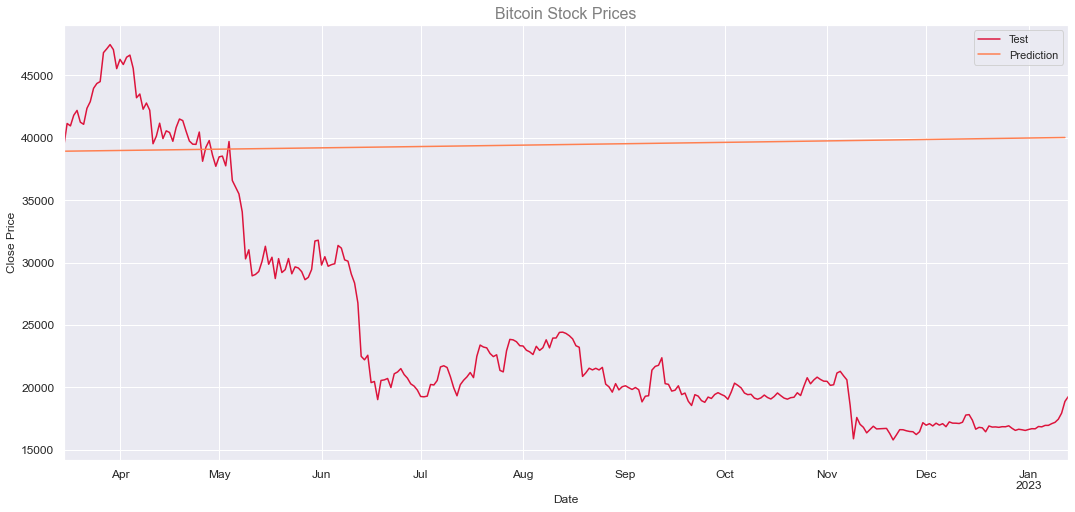

In [55]:
# Graph:

df_train_graph = df_train.set_index('date')
df_test_graph = df_test.set_index('date')


sns.set_theme()
#df_train_graph.close.plot( figsize=(18,8), fontsize=12, label='Train', color='DarkCyan')
df_test_graph.close.plot(figsize=(18,8), fontsize=12, label='Test', color='Crimson')
y_pred.close.plot(figsize=(18,8), fontsize=12, label='Prediction', color='Coral')
plt.legend()
plt.title("Bitcoin Stock Prices", fontsize=16, color='Grey')
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.show()

In [ ]:
#model2.get_leaderboard()
#model2.plot_cv_scores()

In [ ]:
#prediction2 = model2.predict()
#forecast2 = prediction2.forecast
#print("Stock Price Prediction of Bitcoin2")
#print(forecast2)

In [ ]:
#mean_squared_error(df_test, forecast2)

In [ ]:
#mean_squared_error(df_test, forecast2, squared=False)

In [ ]:
#mean_absolute_percentage_error(df_test, forecast2)